# Image Calibration
There is some basic processing that all astronomical images must go through before scientific analysis can be performed. The raw images taken by your detector contain noise and fluctuations due to the detector itself, as well as other artifacts such as cosmic rays. We are not interested in any of these things, so we do some basic calibration to get rid of them. 

1. __Bias subtraction__ -- Every CCD camera applies some non-zero voltage to the CCD chips, and this appears as a constant count across the whole chip. We need to subtract this out. Bias frames are produced by taking a 0s exposure with the shutter closed
2. __Dark Current__ -- Counts in a CCD pixel are determined by measuring the voltage in the pixel, which is created by freeing electrons. Thermal energy in the detector can also free electrons, however these don't represent photons from our source! We need to subtract them out. Dark frames are produced by taking exposures with the shutter closed. The exposure length of your dark frame must match that of your science image(s). A cryogenically cooled detector probably will not need dark frames taken.
3. __Flat Fielding__ -- The flat field accounts for varying sensitivity from pixel to pixel in the detector. It is produced by taking several exposures of a uniformly illuminated field, averaging the exposures together, and dividing the bias- and dark-subtracted image by the result

The above are the *bare minimum* reduction steps you must complete. The following are also very common and useful, and performed after the above:
* Comsic ray removal -- if you have more than one image of the same field, cosmic rays can be removed by taking the median of all exposures.
* Cosmetic artifact removal -- 
* Photometric calibration -- turning electrons counted by the detector into magnitudes or fluxes. This requires measuring well-known stars and comparing their values to our objects of interest
* Image coaddition -- with several images of the same field, one can increase the signal-to-noise by coadding, or averaging, the images together. This works because the noise is inversely proportional to the square root of the total number of counts.


## Creating the master calibration files
Ok, enough talk. Let's get started! We first need to create our "master" calibration files before we can start reducing anything. For the following sections, I'll be assuming that you have more than one of each type of calibration file. I'll also assume that your directory structure is something like (though you can certainly change the code in this notebook to match your directory structure)

```
project
│
└───calibration
│   │
│   └───bias
│   |   │   bias1.fits
│   |   │   bias2.fits
│   |   │   ...
│   │
│   └───dark
│   |   │   dark_30s_1.fits
│   |   │   dark_30s_2.fits
│   |   │   ...
│   │
│   └───flat
│       │   flat1.fits
│       │   flat2.fits
│       │   ...
│   
└───science
    │   rawimage1.fits
    │   rawimage2.fits
    |   ...
```

These are the modules we'll be using:

In [1]:
import glob
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

# ignore annoying astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

plt.style.use('seaborn-notebook') # Make the default figure settings a bit bigger
%matplotlib inline

datadir = 'Sampledata/spectroscopy/'
sciencedir = datadir+'science/'

### Master Bias
The general procedure is to take the average of your bias frames as your master bias. It is important to create the master bias first, since every other master file will need to use it.

In [2]:
# Create a filepath "glob" (list) of all bias frames
bias_subdir = 'calibration/bias/'
bias_files = glob.glob(datadir+bias_subdir+'*.fits')

bias_data = [fits.getdata(b) for b in bias_files]
master_bias = np.median(bias_data, axis=0)  # axis=0 retains the shape of the original array

Let's examine the bias data by plotting a histogram of the flattened data

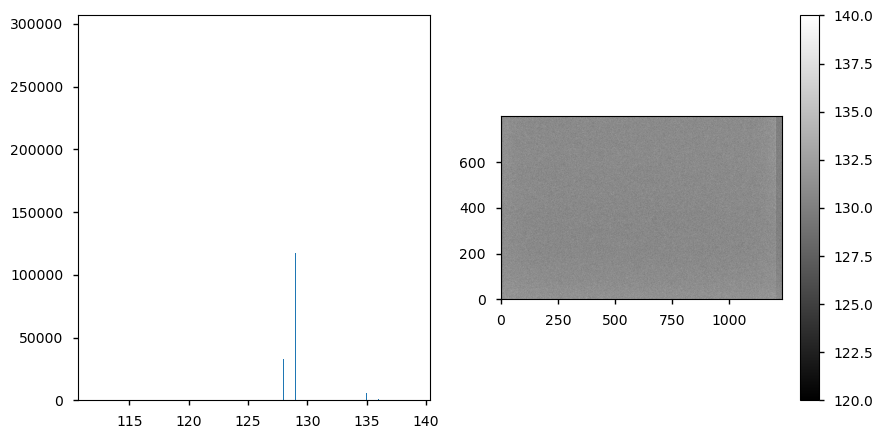

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
hist = ax1.hist(master_bias.flatten(), bins=1000)
img = plt.imshow(master_bias, cmap='gray', vmin=120, vmax=140, origin='lower')#,ax=ax2)
plt.colorbar();

We can see very clearly that the four CCDs that comprise our detector each have slightly different voltages applied across them, leading to different on counts on each. Subtracting the bias frames from our science images will correct this!

Okay, great, let's save our master bias data as a FITS file, just so we have it. We'll just use the header of the first file in the file list as our FITS header.

In [4]:
master_bias_head = fits.getheader(bias_files[0])
fits.writeto(sciencedir+'master_bias.fits', master_bias, header=master_bias_head, overwrite=True)

### Master Dark
Remember that the counts in the dark frames depend on the exposure time. Thus you need to have at least one dark frame for each exposure time you'll be using. Alternatively, you can take a single long dark frame and scale the exposure time accordingly ($N_{sci,dark} = N_d * \frac{t_{sci}}{t_d}$).

__*IMPORTANT: *__ Never scale the dark frames to longer exposure times! Always scale to shorter exposure times.

If you did not take dark frames or it was not necessary to do so, please change the following cell accordingly

In [5]:
took_darks = False

In [6]:
if took_darks:
    dark_subdir = 'calibration/dark/'
    dark_files = glob.glob(datadir+dark_subdir+'*.fits')

    # We must remove the bias to determine the contribution from only the dark counts
    dark_data = [fits.getdata(d)-master_bias for d in dark_files]
    master_dark = np.average(dark_data, axis=0)
    
    master_dark_head = fits.getheader(dark_files[0])
    fits.writeto(sciencedir+dark_subdir+'master_dark.fits', master_dark, 
                 header=master_dark_head, overwrite=True)
else:
    # Just create an array of zeros with the same dimensions as our data.
    # We'll use the master bias to determine these dimensions
    data_shape = np.shape(master_bias)
    master_dark = np.zeros(shape=data_shape)
    
    fits.writeto(sciencedir+'master_dark.fits', master_dark, overwrite=True)

### Master Flat
**Disclaimer: this section uses flats from 2019 and a science image from 2015 because flats were unavailable for 2015. But the general procedure should remain the same.**

The general procedure is to take the median of all flat field exposures. This will be used to scale more sensitive pixels down and less sensitive pixels up, with the net result of uniform sensitivity across the image.

It is common practice to normalize the combined flat field to its median across the entire detector so that pixels with a sensitivity response near the median have a correction factor of ~1. This also ensures that the pixel counts in the final image are nearly equal to ADUs.

In [7]:
flat_subdir = 'calibration/flat/'
flat_files = glob.glob(datadir+flat_subdir+'*.fits')

# Again, we need to remove the bias counts from all flat field exposures to 
# determine the contribution from just the flats
# flat_data = [fits.getdata(f)-master_bias for f in flat_files]
flat_data = [np.subtract(fits.getdata(f),master_bias) for f in flat_files]
master_flat = np.median(flat_data, axis=0)
master_flat = master_flat/np.median(master_flat)

Let's now examine the master flat to see how it looks

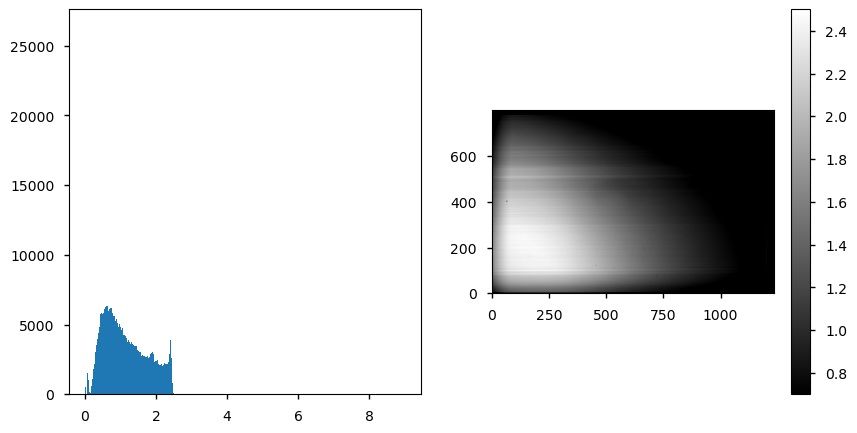

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
hist = ax1.hist(master_flat.flatten(), bins=1000)
img = plt.imshow(master_flat, cmap='gray',vmin=0.7, vmax=2.5, origin='lower')
plt.colorbar();

In [9]:
master_flat_head = fits.getheader(flat_files[0])
fits.writeto(sciencedir+'master_flat.fits', master_flat, 
             header=master_flat_head, overwrite=True)

## Creating the Spectral Flat Field

Flat-fielding in spectroscopy is a little different than for photometry. As you can see in the image above, there is flux variation both in the spatial direction (y-axis or rows) and in the wavelength direction (x-axis or columns). These do not actually represent variation in the pixels themselves, but rather the spectral features of the light source used for the flats -- we need to correct for these effects!

We will base this section on some code I found from Ian Cross at UCSC, who wrote a plethora of useful python code for manipulating spectroscopic data. All of his code can be found here: https://people.ucsc.edu/~ianc/python/_modules/

In particular, we will make use of his `make_spectral_flats` function (in addition to a few others that this function relies on) -- the code is available in the file `spectral_flat_tools.py`, imported below and also included in this repo.

The basic procedure for constructing a spectral flat field is:
1. Select the region of the FITS image where your spectrum is. Your spectrum might be on a slight slant on the CCD, so make sure your region fully includes both ends of the spectrum.
2. Extract that region from your master flat file (accomplished by `extractSubregion` in `spectral_flat_tools.py`)
3. Normalize the region in the x direction (wavelength) by fitting a polynomial to the counts of each **row** of the region and divide each pixel's value by the fitted polynomial value for that pixel (accomplished by `makexflat` in `spectral_flat_tools.py`)
4. Normalize the region in the y direction (spatial) by fitting a polynomial to the counts of each **column** of the region, and divide each pixel's value by the fitted y-polynomial value for that pixel

Then, we need to create our corrected master flat image -- we do this by simply creating a `numpy` array that is the size of our original image and filled with ones, and then setting our selected region of this new array equal to our corrected subregion.

All of these steps are encompassed nicely in the `make_spectral_flats` function. (Though I encourage you to look through the code and learn what is actually happening, rather than accepting this as a black box!)

In [10]:
from spectral_flat_tools import make_spectral_flats

In [11]:
subregion = [[0,1200,270,400],
            [0,1200,500,600]] # list of lists (for functionality with multiple regions)
                              # Each list has the form [xmin, xmax, ymin, ymax]
                              # Make sure your regions are large enough for both your spectrum and for estimation
                              # of sky background!

corrected_flatfield = make_spectral_flats(master_flat, subregion)
fits.writeto(sciencedir+'master_flat_corrected.fits', corrected_flatfield, 
             header=master_flat_head, overwrite=True)

Done with subregion 1
Done with subregion 2


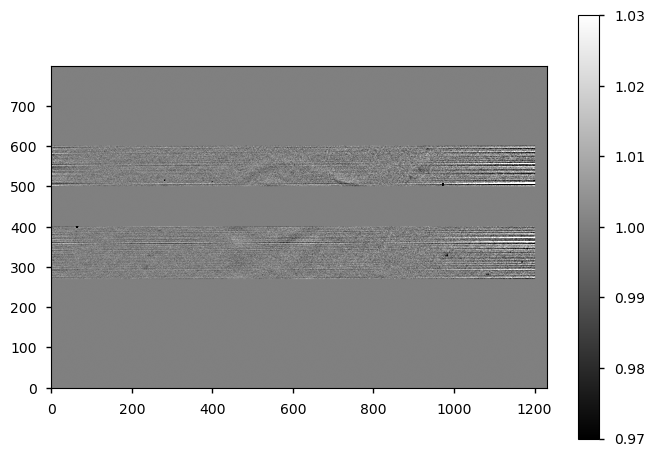

In [12]:
img = plt.imshow(corrected_flatfield, cmap='gray',vmin=0.97, vmax=1.03, origin='lower')
plt.colorbar();

## Calibrating the Raw Images
Now that we have all of our master files, we can apply them to our raw science images. Let's again think about how each affects the counts recorded by our detector:

* The bias corresponds to a constant voltage applied over the entire CCD, which in turn corresponds to a certain number of electrons. We need to __subtract__ this out.
* The dark frames correspond to thermal energy inside the detector causing the electron count to increase (not photons from our source). We need to __subtract__ this out.
* The flat fields correspond to non-uniform sensitivity of the pixels across the detector. We need to __scale__ according to the flat fields so that we have a uniform sensitivity.

The formula is then: $calibrated = \frac{raw - master\_bias - master\_dark}{master\_flat}$

In [13]:
science_files = glob.glob(sciencedir+'ccds150511.0018.fits')
science_data = [fits.getdata(s) for s in science_files]

calibrated_data = (science_data - master_bias - master_dark)/ corrected_flatfield

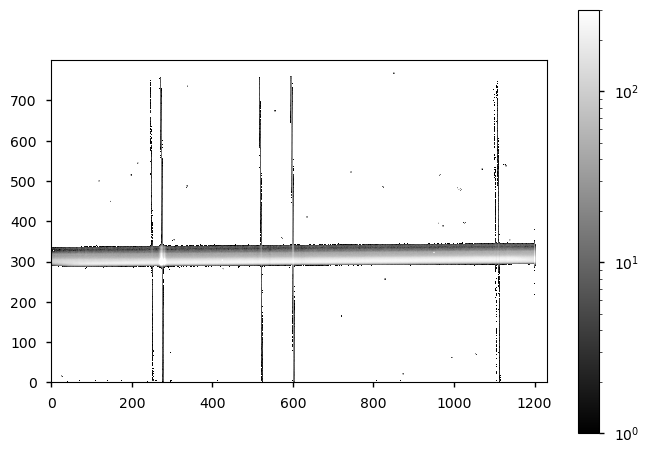

In [14]:
calibrated_data_head = fits.getheader(science_files[0])
fits.writeto(sciencedir+'calibrated.fits', calibrated_data[0], 
             header=calibrated_data_head, overwrite=True)

# vmin and vmax can be determined by plotting a histogram of the flattened image data
plt.imshow(calibrated_data[0], cmap='gray', norm=LogNorm(vmin=1, vmax=300), origin='lower')
plt.colorbar();

You now have a calibrated images ready for analysis!